In [1]:
import os
from pathlib import Path
from typing import Optional
import numpy as np
import lightning as L
import torch
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from minerva.data.datasets.supervised_dataset import SimpleDataset
from minerva.data.readers.png_reader import PNGReader
from minerva.data.readers.tiff_reader import TiffReader
from minerva.transforms.transform import _Transform, TransformPipeline
from torchmetrics import JaccardIndex
import tqdm

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:54: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


## Variables

In [ ]:
model_name = "DinoV2-MLA"
dataset_name = "seam_ai"
image_dir = Path("/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images")
annotations_dir = Path("/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations")
image_height = 1008
image_width = 590
image_channels = 1
batch_size = 1      # Plase set this to 1
num_classes = 6
predict_on_partition = "test"
ckpt_path = Path("/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/ckpt/epoch=0.ckpt")
device = "cuda" if torch.cuda.is_available() else "cpu"
print_crosslines_every = 50
output_dir = Path(f"./logs/{dataset_name}/{model_name}/")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory: {output_dir}")

Output directory: logs/seam_ai/DinoV2-MLA


## Helper functions

In [3]:
def plot_images(
    images,
    plot_title=None,
    subplot_titles=None,
    cmaps=None,
    filename=None,
    x_label=None,
    y_label=None,
    height=5,
    width=5,
    show=False
):
    num_images = len(images)

    # Create a figure with subplots (1 row, num_images columns), adjusting size based on height and width parameters
    fig, axs = plt.subplots(1, num_images, figsize=(width * num_images, height))

    # Set overall plot title if provided
    if plot_title is not None:
        fig.suptitle(plot_title, fontsize=16)

    # Ensure subplot_titles and cmaps are lists with correct lengths
    if subplot_titles is None:
        subplot_titles = [None] * num_images
    if cmaps is None:
        cmaps = ["gray"] * num_images

    # Plot each image in its respective subplot
    for i, (img, ax, title, cmap) in enumerate(
        zip(images, axs, subplot_titles, cmaps)
    ):
        im = ax.imshow(img, cmap=cmap)

        # Set title for each subplot if provided
        if title is not None:
            ax.set_title(title)

        # Add a colorbar for each subplot
        fig.colorbar(im, ax=ax)

        # Set x and y labels if provided
        if x_label:
            ax.set_xlabel(x_label)
        if y_label:
            ax.set_ylabel(y_label)

    # Adjust layout to fit titles, labels, and colorbars
    plt.tight_layout()

    # Save the figure if filename is provided
    if filename is not None:
        plt.savefig(filename, bbox_inches="tight")
        print(f"Figure saved as '{filename}'")

    # Show the plot
    if show:
        plt.show()
    else:
        plt.close()

In [4]:
import hashlib
from pathlib import Path

def hash_file(filepath):
    """Generate a hash for a file."""
    hasher = hashlib.sha256()
    with filepath.open('rb') as file:
        while chunk := file.read(8192):  # Read in 8 KB chunks
            hasher.update(chunk)
    return hasher.hexdigest()

def hash_folder(folder_path):
    """Generate a hash for a folder by hashing its files and structure."""
    hasher = hashlib.sha256()
    folder = Path(folder_path)
    
    files = list(sorted(folder.rglob('*')))  # Get all files and directories
    
    for path in tqdm.tqdm(files, desc="Hashing files..."):  # Recursively iterate over all files and directories
        if path.is_file():
            hasher.update(hash_file(path).encode('utf-8'))  # Hash file content
        hasher.update(str(path.relative_to(folder)).encode('utf-8'))  # Hash relative path for structure
    
    return hasher.hexdigest()

In [5]:
image_folder_hash = hash_folder(image_dir)
annotations_folder_hash = hash_folder(annotations_dir)
print(f"Image folder hash: {image_folder_hash[:8]} and Annotations folder hash: {annotations_folder_hash[:8]}")

Hashing files...:   0%|          | 0/1375 [00:00<?, ?it/s]

Hashing files...: 100%|██████████| 1375/1375 [00:00<00:00, 1841.75it/s]

Image folder hash: 9799486b and Annotations folder hash: 2566b002


## Transforms

In [6]:
class PadCrop(_Transform):
    """Transforms image and pads or crops it to the target size.
    If the axis is larger than the target size, it will crop the image.
    If the axis is smaller than the target size, it will pad the image.
    """

    def __init__(
        self,
        target_h_size: int,
        target_w_size: int,
        padding_mode: str = "reflect",
        seed: int | None = None,
        constant_values: int = 0,
    ):
        """
        Initializes the transformation with target sizes, padding mode, and RNG seed.

        Parameters:
        - target_h_size (int): The target height size.
        - target_w_size (int): The target width size.
        - padding_mode (str): The padding mode to use (default is "reflect").
        - seed (int): Seed for random number generator to make cropping reproducible.
        """
        self.target_h_size = target_h_size
        self.target_w_size = target_w_size
        self.padding_mode = padding_mode
        self.rng = np.random.default_rng(
            seed
        )  # Random number generator with the provided seed
        self.constant_values = constant_values

    def __call__(self, x: np.ndarray) -> np.ndarray:
        h, w = x.shape[:2]
        # print(f"-> [{self.__class__.__name__}] x.shape={x.shape}")

        # Handle height dimension independently: pad if target_h_size > h, else crop
        if self.target_h_size > h:
            pad_h = self.target_h_size - h
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            pad_args = {
                "array": x,
                "pad_width": (
                    ((pad_top, pad_bottom), (0, 0), (0, 0))
                    if len(x.shape) == 3
                    else ((pad_top, pad_bottom), (0, 0))
                ),
                "mode": self.padding_mode,
            }
            if self.padding_mode == "constant":
                pad_args["constant_values"] = self.constant_values

            x = np.pad(**pad_args)

        elif self.target_h_size < h:
            crop_h_start = self.rng.integers(0, h - self.target_h_size + 1)
            x = x[crop_h_start : crop_h_start + self.target_h_size, ...]

        # Handle width dimension independently: pad if target_w_size > w, else crop
        if self.target_w_size > w:
            pad_w = self.target_w_size - w
            pad_left = pad_w // 2
            pad_right = pad_w - pad_left

            pad_args = {
                "array": x,
                "pad_width": (
                    ((0, 0), (pad_left, pad_right), (0, 0))
                    if len(x.shape) == 3
                    else ((0, 0), (pad_left, pad_right))
                ),
                "mode": self.padding_mode,
            }

            if self.padding_mode == "constant":
                pad_args["constant_values"] = self.constant_values

            x = np.pad(**pad_args)

        elif self.target_w_size < w:
            crop_w_start = self.rng.integers(0, w - self.target_w_size + 1)
            x = x[:, crop_w_start : crop_w_start + self.target_w_size, ...]

        # Ensure channel dimension consistency
        if len(x.shape) == 2:  # For grayscale, add a channel dimension
            x = np.expand_dims(x, axis=2)

        # Convert to torch tensor with format C x H x W
        # output = torch.from_numpy(x).float()
        x = np.transpose(x, (2, 0, 1))  # Convert to C x H x W format
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        # print(f"<- [{self.__class__.__name__}] x.shape={x.shape}")
        return x

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(target_h_size={self.target_h_size}, target_w_size={self.target_w_size})"

    def __repr__(self) -> str:
        return str(self)


class SelectChannel(_Transform):
    """Perform a channel selection on the input image."""

    def __init__(self, channel: int, expand_channels: int = None):
        """
        Initializes the transformation with the channel to select.

        Parameters:
        - channel (int): The channel to select.
        """
        self.channel = channel
        self.expand_channels = expand_channels

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = x[self.channel, ...]
        if self.expand_channels is not None:
            x = np.expand_dims(x, axis=self.expand_channels)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(channel={self.channel})"

    def __repr__(self) -> str:
        return str(self)


class CastTo(_Transform):
    def __init__(self, dtype: type):
        """
        Initializes the transformation with the target data type.

        Parameters:
        - dtype (type): The target data type.
        """
        self.dtype = dtype

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x.astype(self.dtype)

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(dtype={self.dtype})"

    def __repr__(self) -> str:
        return str(self)


class SwapAxes(_Transform):
    def __init__(self, source_axis: int, target_axis: int):
        """
        Initializes the transformation with the source and target axes.

        Parameters:
        - source_axis (int): The source axis to swap.
        - target_axis (int): The target axis to swap.
        """
        self.source_axis = source_axis
        self.target_axis = target_axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.swapaxes(x, self.source_axis, self.target_axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(source_axis={self.source_axis}, target_axis={self.target_axis})"

    def __repr__(self) -> str:
        return str(self)


class RepeatChannel(_Transform):
    def __init__(self, repeats: int, axis: int):
        """
        Initializes the transformation with the number of repeats.

        Parameters:
        - repeats (int): The number of repeats.
        - axis (int): The axis to repeat.
        """
        self.repeats = repeats
        self.axis = axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.repeat(x, self.repeats, axis=self.axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(repeats={self.repeats}, axis={self.axis})"

    def __repr__(self) -> str:
        return str(self)


class ExpandDims(_Transform):
    def __init__(self, axis: int):
        """
        Initializes the transformation with the axis to expand.

        Parameters:
        - axis (int): The axis to expand.
        """
        self.axis = axis

    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = np.expand_dims(x, axis=self.axis)
        # print(f"[{self.__class__.__name__}] x.shape={x.shape}")
        return x

    def __str__(self) -> str:
        return f"{self.__class__.__name__}(axis={self.axis})"

    def __repr__(self) -> str:
        return str(self)

## Parihaka DataModule Definition

In [7]:
class GenericParihakaDataModule(L.LightningDataModule):
    class Identity(_Transform):
        def __call__(self, x: np.ndarray) -> np.ndarray:
            return x
    
    def __init__(
        self,
        root_data_dir: str,
        root_annotation_dir: str,
        image_transforms: TransformPipeline,
        label_transforms: TransformPipeline,
        batch_size: int = 1,
        num_workers: Optional[int] = None,
        predict_on: str = "test",
    ):
        assert predict_on in ["test", "val", "train"]
        
        super().__init__()
        self.root_data_dir = Path(root_data_dir)
        self.root_annotation_dir = Path(root_annotation_dir)
        self.image_transforms = image_transforms or self.Identity()
        self.label_transforms = label_transforms or self.Identity()
        self.batch_size = batch_size
        self.num_workers = (
            num_workers if num_workers is not None else os.cpu_count()
        )
        self.predict_on = predict_on
        self.datasets = {}

    def _create_dataset(self, partition: str):
        img_reader = TiffReader(str(self.root_data_dir / partition))
        label_reader = PNGReader(str(self.root_annotation_dir / partition))
        return SimpleDataset(
            readers=[img_reader, label_reader],
            transforms=[self.image_transforms, self.label_transforms],
        )
        
    def _get_dataloader(self, partition: str, shuffle: bool):
        return DataLoader(
            self.datasets[partition],
            batch_size=self.batch_size,
            num_workers=self.num_workers, # type: ignore
            shuffle=shuffle,
        )

    def setup(self, stage=None):        
        if stage == "fit":
            self.datasets["train"] = self._create_dataset("train")
            self.datasets["val"] = self._create_dataset("val")
        elif stage == "test":
            self.datasets["test"] = self._create_dataset("test")
        elif stage == "predict":
            self.datasets["predict"] = self._create_dataset(self.predict_on)
        else:
            raise ValueError(f"Invalid stage: {stage}")

    def train_dataloader(self):
        return self._get_dataloader("train", shuffle=True)

    def val_dataloader(self):
        return self._get_dataloader("val", shuffle=False)

    def test_dataloader(self):
        return self._get_dataloader("test", shuffle=False)

    def predict_dataloader(self):
        return self._get_dataloader("predict", shuffle=False)

    def __str__(self) -> str:
        return f"""DataModule
    Data: {self.root_data_dir}
    Annotations: {self.root_annotation_dir}
    Batch size: {self.batch_size}"""

    def __repr__(self) -> str:
        return str(self)
    

# Helper functions (if needed)
def get_train_dataloader(data_module):
    data_module.setup("fit")
    return data_module.train_dataloader()

def get_val_dataloader(data_module):
    data_module.setup("fit")
    return data_module.val_dataloader()

def get_test_dataloader(data_module):
    data_module.setup("test")
    return data_module.test_dataloader()

def get_predict_dataloader(data_module):
    data_module.setup("predict")
    return data_module.predict_dataloader()

## Transforms instantiation

In [8]:
image_transforms = []
image_transforms.append(SwapAxes(0, -1))
image_transforms.append(SelectChannel(0))
image_transforms.append(SwapAxes(0, 1))
image_transforms.append(PadCrop(image_height, image_width, padding_mode="reflect", seed=42))
if image_channels > 1:
    image_transforms.append(RepeatChannel(image_channels, axis=0))
image_transforms.append(CastTo(np.float32))


label_transforms = []
label_transforms.append(PadCrop(image_height, image_width, padding_mode="reflect", seed=42))
label_transforms.append(CastTo(np.float32))

print(f"Image transforms: {image_transforms}")
print(f"Label transforms: {label_transforms}")

Image transforms: [SwapAxes(source_axis=0, target_axis=-1), SelectChannel(channel=0), SwapAxes(source_axis=0, target_axis=1), PadCrop(target_h_size=1008, target_w_size=590), CastTo(dtype=<class 'numpy.float32'>)]
Label transforms: [PadCrop(target_h_size=1008, target_w_size=590), CastTo(dtype=<class 'numpy.float32'>)]


## Defining Data Module

In [9]:
data_module = GenericParihakaDataModule(
    root_data_dir=str(image_dir),
    root_annotation_dir=str(annotations_dir),
    image_transforms=TransformPipeline(image_transforms),
    label_transforms=TransformPipeline(label_transforms),
    batch_size=batch_size,
)

data_module

DataModule
    Data: /workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images
    Annotations: /workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations
    Batch size: 1

In [10]:
train_batch_x, train_batch_y = next(iter(get_train_dataloader(data_module)))
print(f"Train batch X shape: {train_batch_x.shape}")
print(f"Train batch Y shape: {train_batch_y.shape}")

Train batch X shape: torch.Size([1, 1, 1008, 590])
Train batch Y shape: torch.Size([1, 1, 1008, 590])


In [11]:
print(f"O Batch (de tamanho {train_batch_x.shape[0]}) possui: {train_batch_x.shape[1]} canais, {train_batch_x.shape[2]} altura e {train_batch_x.shape[3]} largura.")

O Batch (de tamanho 1) possui: 1 canais, 1008 altura e 590 largura.


# Define and load model here

In [12]:
class DummyModel(torch.nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, x):
        y_hat = torch.randint_like(x, 0, self.num_classes)
        y_hat = torch.randn(x.shape[0], self.num_classes, x.shape[2], x.shape[3], device=x.device)
        return y_hat

def get_model(ckpt_path) -> torch.nn.Module:
    """Create and load a model from a checkpoint."""
    # ckpt = torch.load(ckpt_path)
    return DummyModel(num_classes)

model = get_model(ckpt_path)

## Evaluate model

Testing: 42it [00:00, 90.21it/s]

Crossline 50 MIOU: 0.07044152915477753
x.shape=(1008, 590), y.shape=(1008, 590), y_hat.shape=(1008, 590), diff.shape=(1008, 590)
Figure saved as 'logs/seam_ai/DinoV2-MLA/segmentation_50.png'


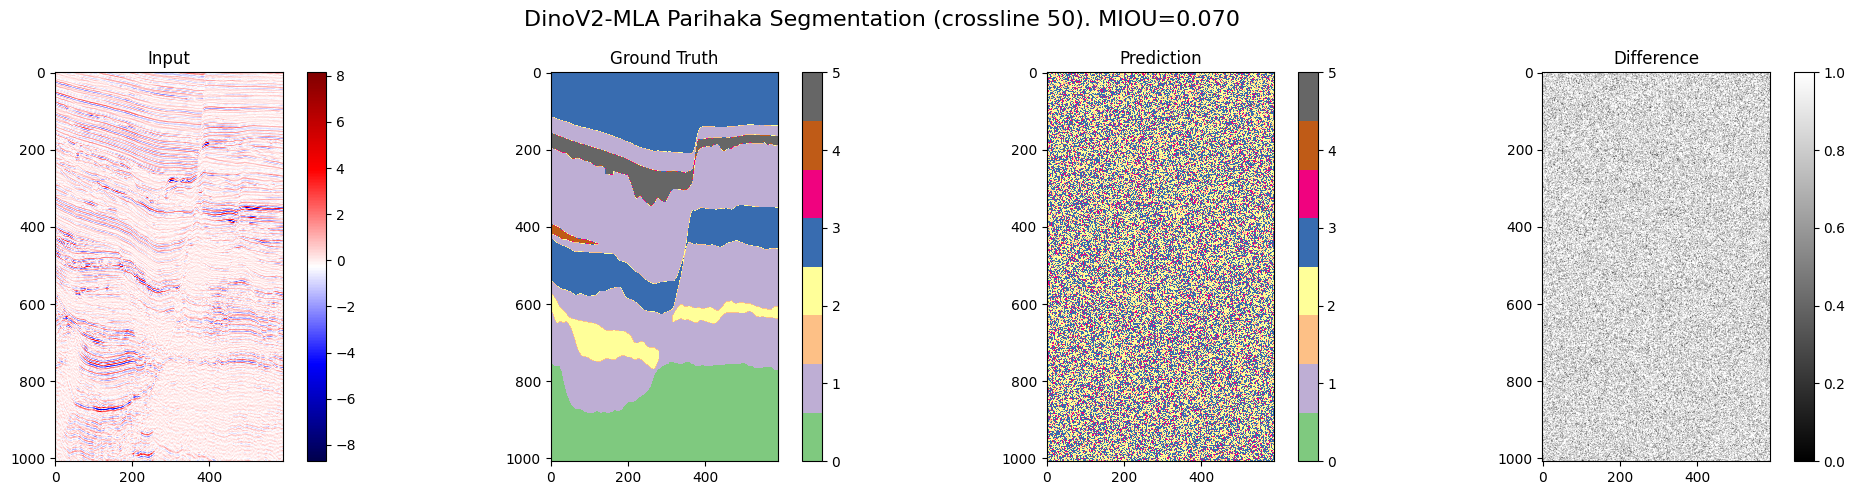

Testing: 99it [00:02, 61.74it/s]

Crossline 100 MIOU: 0.0714789479970932
x.shape=(1008, 590), y.shape=(1008, 590), y_hat.shape=(1008, 590), diff.shape=(1008, 590)
Figure saved as 'logs/seam_ai/DinoV2-MLA/segmentation_100.png'


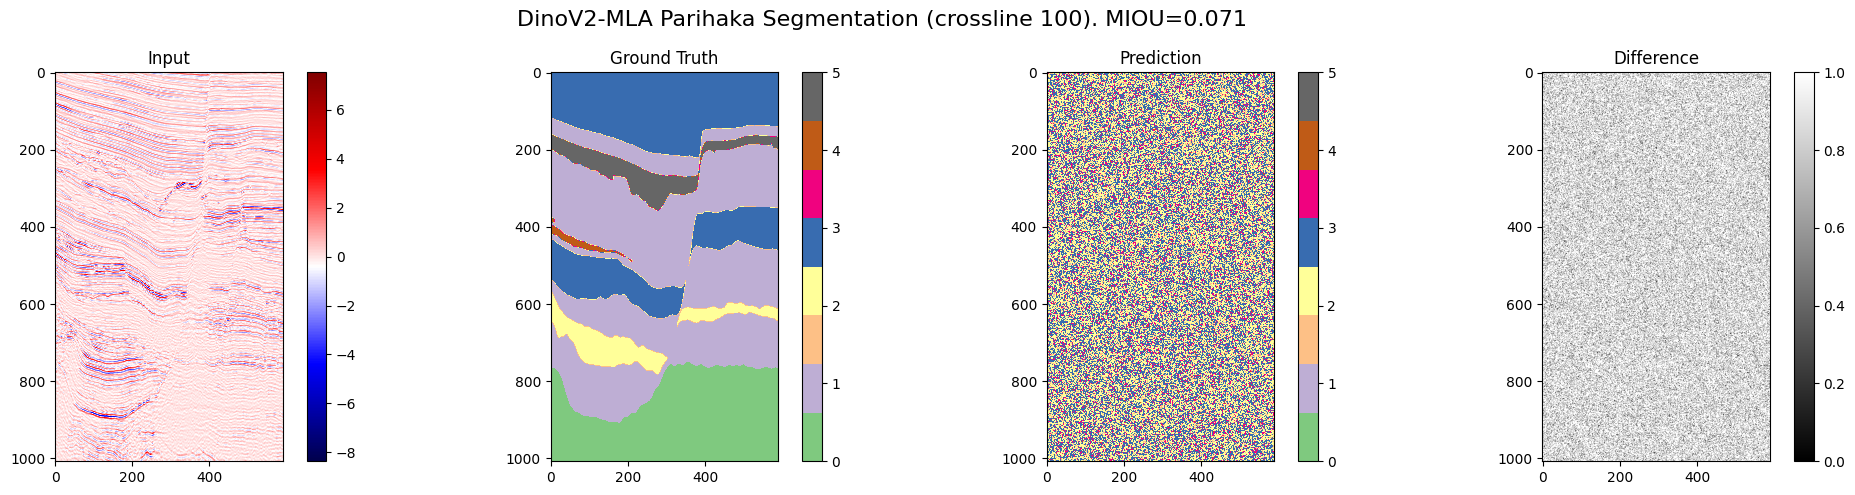

Testing: 135it [00:03, 41.08it/s]

Crossline 150 MIOU: 0.06943055987358093
x.shape=(1008, 590), y.shape=(1008, 590), y_hat.shape=(1008, 590), diff.shape=(1008, 590)
Figure saved as 'logs/seam_ai/DinoV2-MLA/segmentation_150.png'


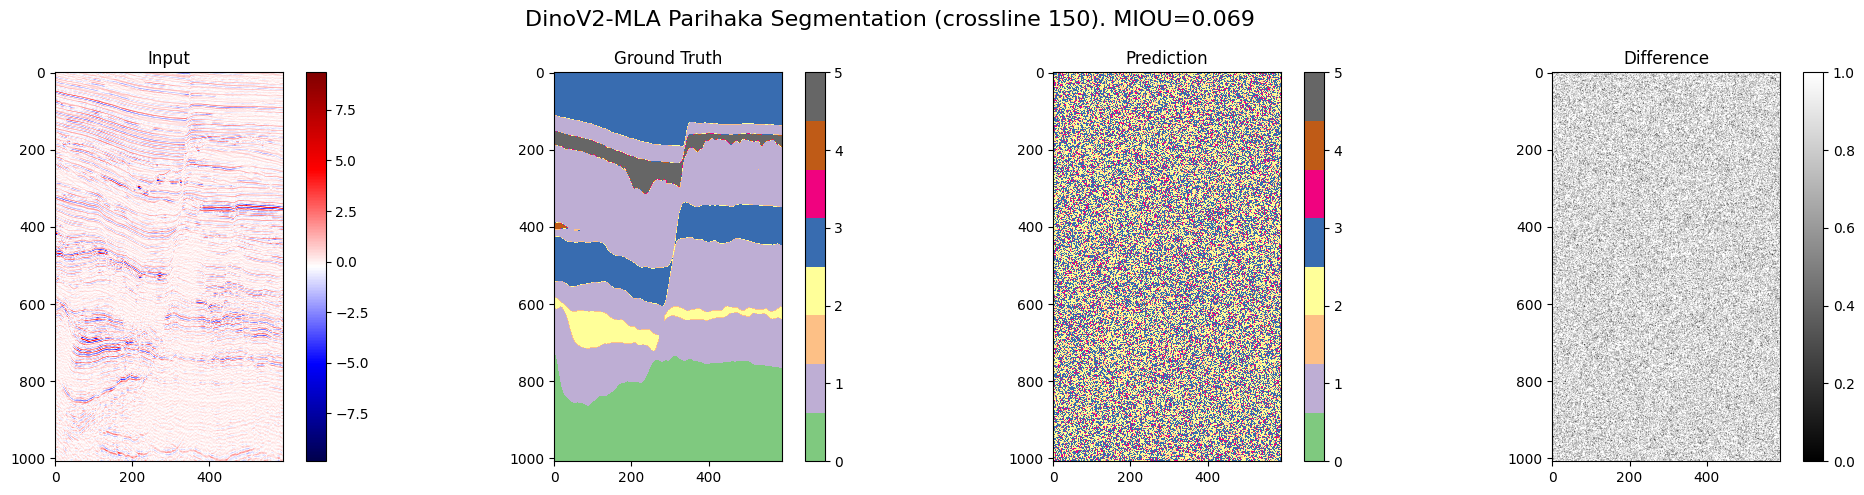

Testing: 171it [00:04, 37.83it/s]

Crossline 200 MIOU: 0.07023775577545166
x.shape=(1008, 590), y.shape=(1008, 590), y_hat.shape=(1008, 590), diff.shape=(1008, 590)
Figure saved as 'logs/seam_ai/DinoV2-MLA/segmentation_200.png'


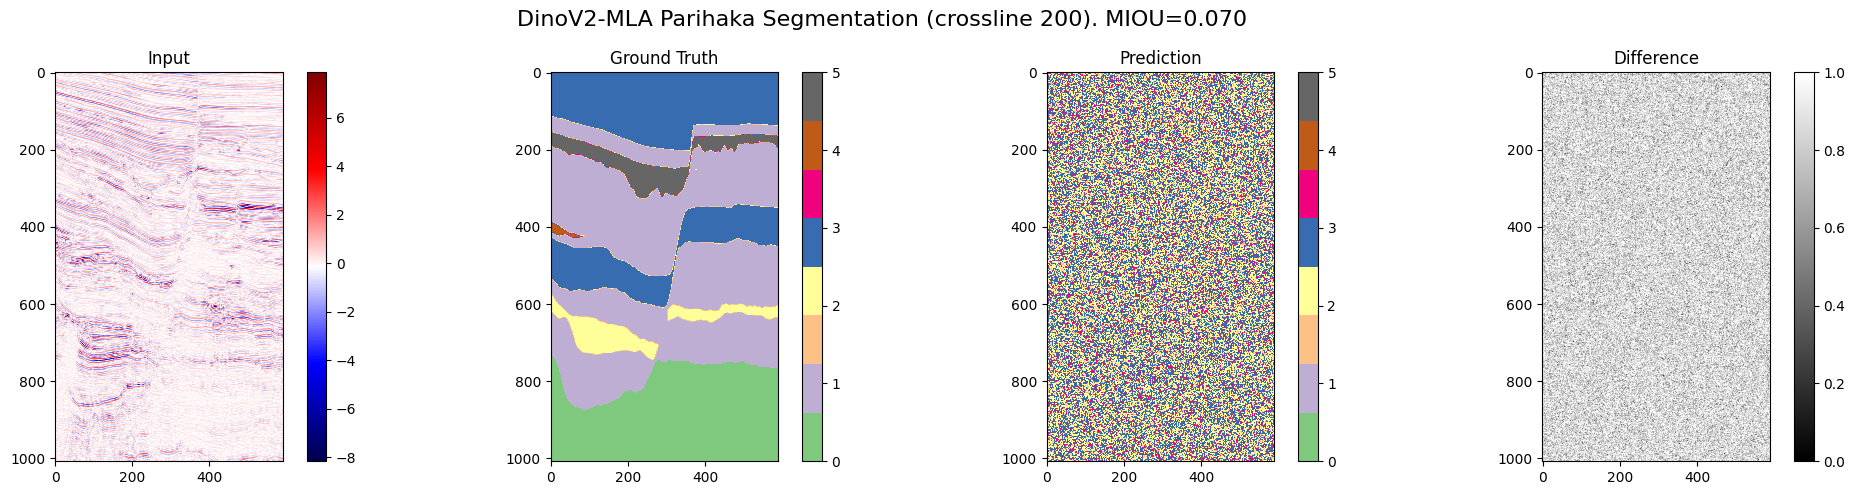

Testing: 200it [00:05, 34.66it/s]


In [13]:
data_module.setup("test")

miou_metric = JaccardIndex(task="multiclass", num_classes=num_classes).to(
    "cuda"
)
metric_values = []

model.eval()
model = model.to("cuda")

curent_index = 0

for batch_idx, (batch_x, batch_y) in tqdm.tqdm(
    enumerate(data_module.test_dataloader()),
    desc="Testing",
    leave=True,
):
    batch_x, batch_y = batch_x.to("cuda"), batch_y.to("cuda")
    batch_y_hat = model.forward(batch_x)
    batch_y_hat = torch.argmax(batch_y_hat, dim=1).unsqueeze(1)

    for i, (x, y, y_hat) in enumerate(zip(batch_x, batch_y, batch_y_hat)):
        curent_index += 1
        res = miou_metric(
            y_hat.unsqueeze(0), y.unsqueeze(0)
        ).item()  # re-add batch dimension (unsqueeze(0))
        metric_values.append(res)

        if curent_index % print_crosslines_every == 0:
            x = x.squeeze(0).cpu().numpy()
            y = y.squeeze(0).cpu().numpy()
            y_hat = y_hat.squeeze(0).cpu().numpy()
            diff = (y != y_hat).astype(np.int32)
            print(f"Crossline {curent_index} MIOU: {res}")
            print(
                f"x.shape={x.shape}, y.shape={y.shape}, y_hat.shape={y_hat.shape}, diff.shape={diff.shape}"
            )

            plot_images(
                images=[x, y, y_hat, diff],
                subplot_titles=[
                    "Input",
                    "Ground Truth",
                    "Prediction",
                    "Difference",
                ],
                cmaps=["seismic", "Accent", "Accent", "gray"],
                plot_title=f"{model_name} Parihaka Segmentation (crossline {curent_index}). MIOU={res:.3f}",
                filename=f"{output_dir}/segmentation_{curent_index}.png",
                show=True,
            )

In [14]:
mean_iou = np.mean(metric_values)
print(f"Mean IoU: {mean_iou:.4f}")
with open(f"{output_dir}/mean_iou.txt", "w") as f:
    f.write(f"{mean_iou:.4f}")

Mean IoU: 0.0703
